<a href="https://colab.research.google.com/github/moustafa-7/League-of-legends_Bigdata/blob/main/Bigdata_miniprojects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## First thing to do is to add those three files to your drive
1. [small_matches.json](https://drive.google.com/file/d/1PKEg_ndTZhSBc9udtfHAqxxAXKvixkj3/view?usp=sharing) (1339 match)
2. [small_matches.jsonl](https://drive.google.com/file/d/1godqh6q0vH7oXb1LpD1qWLFGxMhBjE5N/view?usp=sharing) (3000 match)
3. [champion_class.json](https://drive.google.com/file/d/1QWZIJvt8O-5zvdhl2rV7FvAKlOseoyM4/view?usp=sharing) 

### Now you can all the experiments at once by clicking Runtime (top left) then click "Run all"

## Initial Setup

In [ ]:
!sudo apt install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [ ]:
# !7z e drive/MyDrive/matches.jsonl.7z

In [ ]:
# !head -3000 matches.jsonl > drive/MyDrive/small_matches.jsonl

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

## 0. Import libraries

In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

In [5]:
import findspark
findspark.init()
import pyspark
import random
import time
import matplotlib.pyplot as plt
import pandas as pd
from operator import add

In [6]:
def tags(champion_id):
  for c in champion_classes:
    if champion_id==c["championId"]:
      return c["tags"]

In [7]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("LOL").getOrCreate()
sc = spark.sparkContext

# either reading 1339 or 3000 matches
# d = spark.read.json("drive/MyDrive/small_matches.json", multiLine=True)
d = spark.read.json("drive/MyDrive/small_matches.jsonl", multiLine=False)

In [8]:
no_matches = d.count()
print(no_matches)

3000


In [9]:
import findspark
findspark.init()
import pyspark
import random
import time
import matplotlib.pyplot as plt
import pandas as pd
from operator import add

In [10]:
def tags(champion_id):
  for c in champion_classes:
    if champion_id==c["championId"]:
      return c["tags"]

In [11]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("LOL").getOrCreate()
sc = spark.sparkContext

# either reading 1339 or 3000 matches
# d = spark.read.json("drive/MyDrive/small_matches.json", multiLine=True)
d = spark.read.json("drive/MyDrive/small_matches.jsonl", multiLine=False)

In [12]:
no_matches = d.count()
print(no_matches)

3000


## 1. Champions win - pick - ban rates

In this requirement, we are asked to return the rates of each champion (ban, pick, win, lose) rates

To do so: \
1. Loop over each match and print all participants and ban list (ChampionIds)
2. beside each championId print either (win, lose, ban)
3. Group by keys so we will have (championId, [win, lose, ban, ...........]
4. pass each champion-list to a function that computes rates that returns (champion, (ban, pick, win, lose)).
  - ban is computed by $\frac{ban\_count}{total\_matches\_count}$ \
  - pick is $\frac{played\_matches}{total\_matches\_count}$
  - win and lose by $\frac{won\_or\_lost\_matches}{total\_played\_matches\_count}$

In [163]:
def champions(row):
  """
  This function takes a match and output the following
  A list of all champions in this match either winnign champions or losing champions or banned. and then passed to a flat map
  """
  c = []
  bans = []
  for p in row["participants"]:
    # decide which team is this champion to know either this champion won or lost
    if(p["teamId"] == "Blue"): team_number = 0
    else: team_number = 1
    # append each champion and either won or lost
    c.append((p["championId"], row["teams"][team_number]["win"]))
  
  # loop over banned list and append it to the c (champions) list along with the banned list.
  for t in row["teams"]:
    for b in t["bans"]:
      if(b["championId"] != None):
        c.append((b["championId"],"ban"))

  return c

In [164]:
# get champions (and their tags) by passing the matches to champions functions
champions = d.rdd.flatMap(champions)

In [165]:
import time
def lookup(champions):
  for c in champions.collect():
    print(c)
    time.sleep(0.1)

In [166]:
# group all output values by championId and then convert all tags to a list so the final layout is:
#   championId: list[win, lost, banned, .......]
by_champion = champions.groupByKey().mapValues(list)

In [185]:
def compute_champion_rates(val):
  """
  This function takes a champion and counts how many times it was banned, won, and lost and normalize each rate.
  """
  ban_count = val.count("ban")
  win_count = val.count("Win")
  lose_count = val.count("Fail")
  total_played_games = win_count+lose_count
  
  # some times a champion maybe banned but was never chosen by a user so it just return "never played" instead of win and lose rates
  if(total_played_games):
    return [ban_count/no_matches, total_played_games/no_matches, win_count/total_played_games, lose_count/total_played_games]
  else:
    return [ban_count/no_matches, "never_played", "never_played"]

In [193]:
win_pick_ban_rates = by_champion.map(lambda x:(x[0], compute_champion_rates(x[1]))).filter(lambda x: x[1][2] is not 'never_played')
# ban, pick, win, lose rates in a python list type
champion_rates_list = win_pick_ban_rates.collect()

In [194]:
N = 10

In [ ]:
# sorted(champion_rates_list, key = lambda x : x[1][0])[:10]
champion_rates_list

In [196]:
# sort depending on each rate (top 10)

# top banned
top_banned_champions = sorted(champion_rates_list, key = lambda x: x[1][0], reverse = True)[:N] 

# top picked
top_picked_champions = sorted(champion_rates_list, key = lambda x: x[1][1], reverse = True)[:N] 

# top winning
top_winning_champions = sorted(champion_rates_list, key = lambda x: x[1][2], reverse = True)[:N] 

# top losing
top_losing_champions = sorted(champion_rates_list, key = lambda x: x[1][3], reverse = True)[:N] 

In [199]:
def show_rate(top_rate_champions,rate_category, bar_name):
  c_id, c_rates = zip(*top_rate_champions)
  ban = []
  pick = []
  win = []
  lose = []
  for r in c_rates:
    ban.append(r[0])
    pick.append(r[1])
    win.append(r[2])
    lose.append(r[3])

  c_table = {"id": c_id, "ban": ban, "pick": pick, "win":win, 'lose':lose}

  c_df = pd.DataFrame(c_table, columns = ['id', 'ban', 'pick', 'win', 'lose'])
  width = 0.25
  fig, ax = plt.subplots(figsize=(20,5))
  pos = list(range(len(c_df['id'])))
  plt.bar(c_df["id"], c_df[rate_category], width, alpha=0.5, color='#EE3224')
  ax.set_title(bar_name)
  ax.set_ylabel('rate')
  ax.set_xticklabels(c_df['id'])
  plt.show()


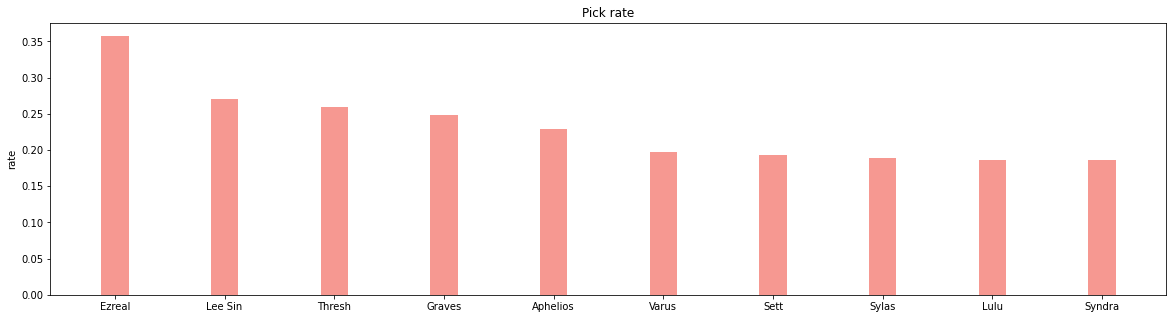

In [202]:
show_rate(top_picked_champions, "pick", "Pick rate")

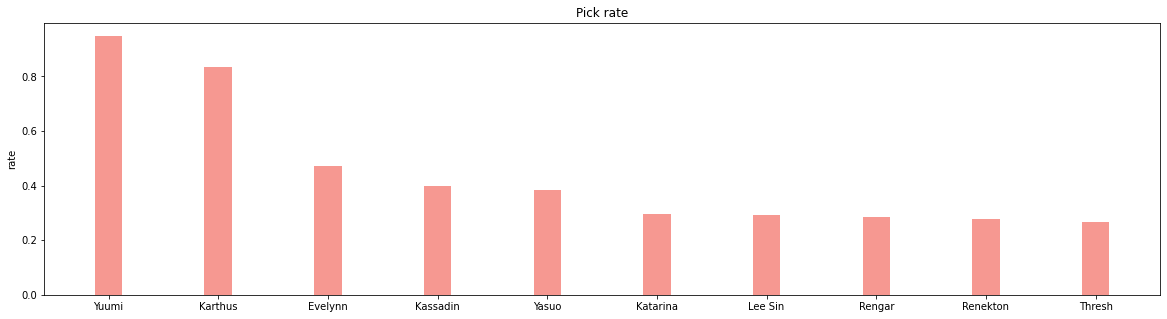

In [203]:
show_rate(top_banned_champions, "ban", "Ban rate")

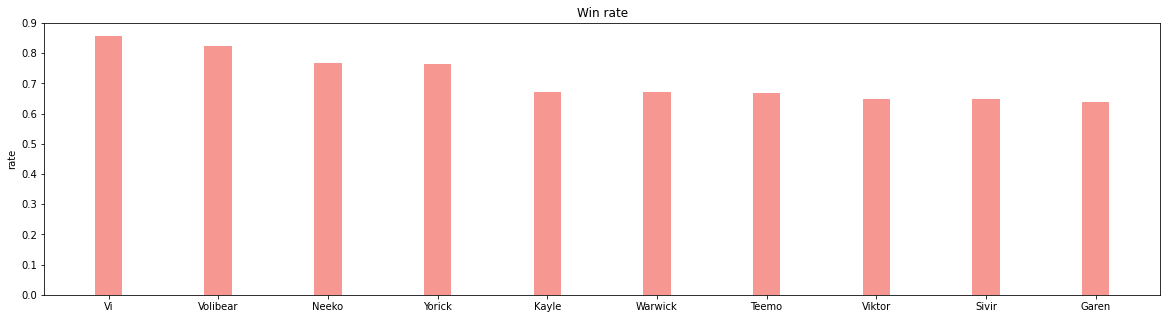

In [205]:
show_rate(top_winning_champions, "win", "Win rate")

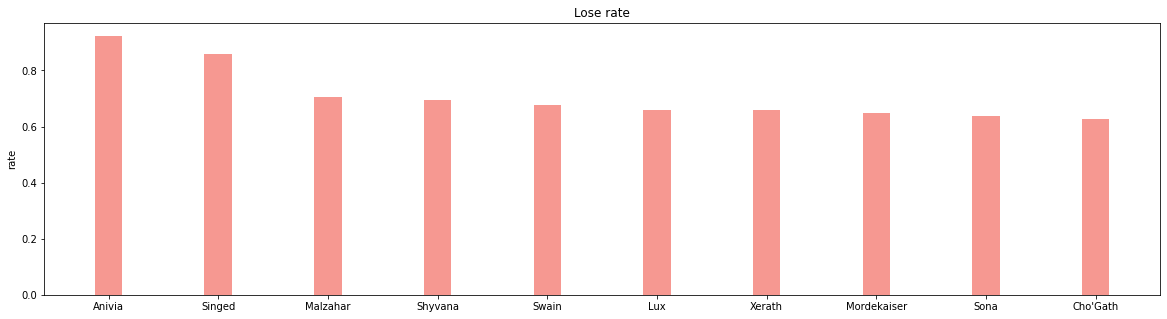

In [206]:
show_rate(top_losing_champions, "lose", "Lose rate")

## 2. Champion Synergies or Duos

To get Champion Duos:
1. Loop over all matches and in each match output all combination (across the team only not 2 teams) so in one game we are supposed to have $2 * 5C_2 = 20$ combinations
2. Each combination is outputed along with either 1 or 1.5 
  - 1 means that this combination lost match
  - 1.5 means that this combination won the match (to give higher weight for winning duo)
  - All combinations are ordered alphabitically so that no duo is replicated
3. Reduce by the score (1 or 1.5) using the sum operation.

In [300]:
import itertools
def champion_duos(row):
  duos = []
  team1 = []
  team2 = []

  # know which team won or lost
  is_team1_win = False
  is_team2_win = False

  # loop over all particiapants
  for p in row["participants"]:
    if(p["teamId"] == "Blue"): 
      team_number = 0
    else: 
      team_number = 1
    
    # save memory each participant in its corresponding team list
    if(team_number == 0):
      team1.append(p["championId"])
      is_team1_win = p["stats"]["win"]
    else:
      team2.append(p["championId"])
      is_team2_win = p["stats"]["win"]

  # Sort alphabitically
  team1 = sorted(team1)
  team2 = sorted(team2)

  # loop over all combinations and produce (combination, 1/1.5)
  for c in list(itertools.combinations(team1, 2)):
    if is_team1_win:
      duos.append((c, 1.5))
    else:
      duos.append((c, 1))

  for c in list(itertools.combinations(team2, 2)):
    if is_team2_win:
      duos.append((c, 1.5))
    else:
      duos.append((c, 1))

  
  return duos

In [301]:
duos_score = d.rdd.flatMap(champion_duos).reduceByKey(add)
duos_score_list =  duos_score.collect()

In [302]:
top_duos = sorted(duos_score_list, key = lambda x: x[1], reverse = True)[:N] 

In [303]:
c_id, c_rates = zip(*top_duos)


def duo_score(bar_name):
  duos, duo_score = zip(*top_duos)

  # get names to be id1_id2
  d = []
  for du in duos:
    d.append(du[0]+'_'+du[1])

  # create dictionary to be a pandas dataframe
  duo_table = {"duo": d, "score": duo_score}

  # plot
  c_df = pd.DataFrame(duo_table, columns = ['duo', 'score'])
  width = 0.25
  fig, ax = plt.subplots(figsize=(20,5))
  plt.bar(c_df["duo"], c_df["score"], width, alpha=0.5, color='#EE3224')
  ax.set_title(bar_name)
  ax.set_ylabel('total Score')
  ax.set_xticklabels(c_df['duo'])
  plt.show()

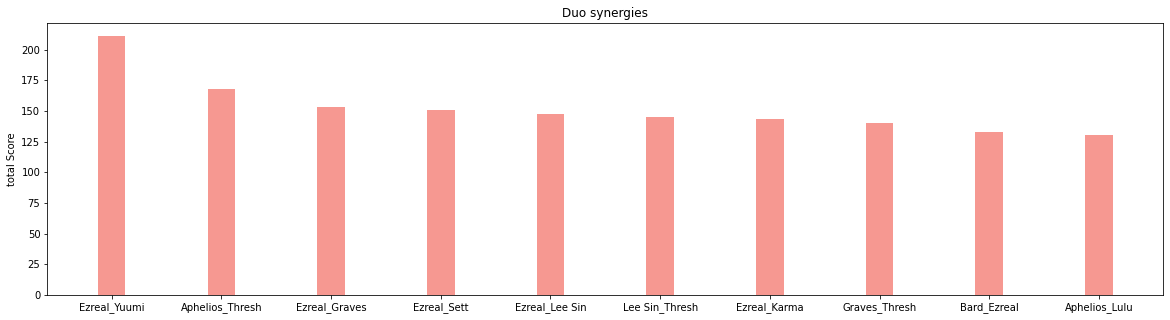

In [304]:
duo_score("Duo synergies")

## 3. Item Win - pick rates

Exactly the same as Champion win and pick rates

In [235]:
def get_items(row):
  # this takes the row and produces the item_id and either its player won or lost
  c = []
  bans = []
  for p in row["participants"]:
    for i in range(7):
      c.append((p["stats"]["item"+str(i)]["name"], p["stats"]["win"]))
  return c

In [236]:
items = d.rdd.flatMap(get_items).groupByKey().mapValues(list)

In [244]:
def compute_item_rates(val):
  win_count = val.count(True)
  lose_count = val.count(False)
  total_played_games = win_count+lose_count
  return [win_count/total_played_games, len(val)/no_matches]

In [297]:
# some times I find None type which is really weird
item_rates = items.map(lambda x:(x[0], compute_item_rates(x[1]))).filter(lambda x: x[0] is not None)
item_rates_list =  item_rates.collect()

In [294]:
def item_rate_bar(rate_type,bar_name):
  if rate_type == "pick":
    top_item_rates = sorted(item_rates_list, key = lambda x: x[1][1], reverse = True)[:N] 
  else:
    top_item_rates = sorted(item_rates_list, key = lambda x: x[1][0], reverse = True)[:N] 

  
  item, rates = zip(*top_item_rates)
  pick = []
  win = []
  for r in rates:
    win.append(r[0])
    pick.append(r[1])  

  
  # create dictionary to be a pandas dataframe
  if r == "pick":
    item_table = {"item": item, "rates": pick}
  else:
    item_table = {"item": item, "rates": win}



  # plot
  c_df = pd.DataFrame(item_table, columns = ['item', 'rates'])
  width = 0.25
  fig, ax = plt.subplots(figsize=(20,5))
  plt.bar(c_df["item"], c_df["rates"], width, alpha=0.5, color='#EE3224')
  ax.set_title(bar_name)
  ax.set_ylabel(rate_type+' rate')
  ax.set_xticklabels(c_df['item'])
  plt.show()

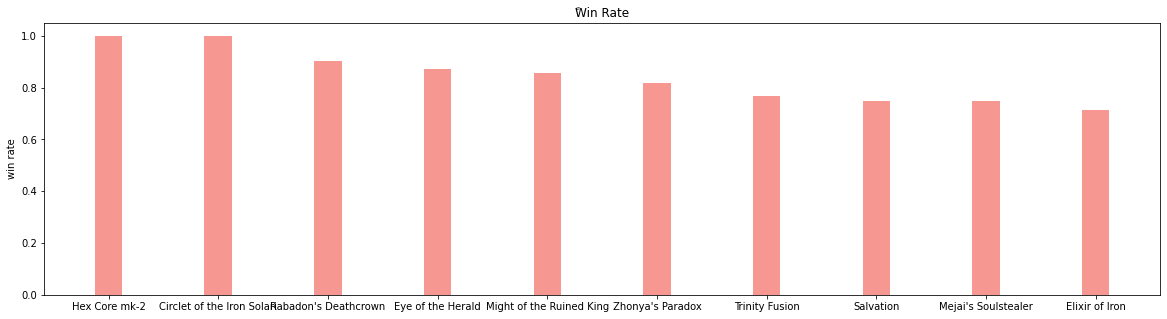

In [298]:
item_rate_bar("win","ًWin Rate")

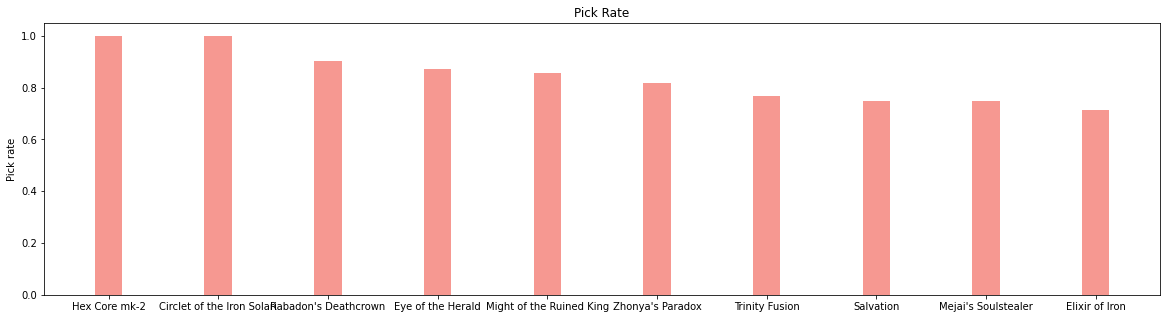

In [299]:
item_rate_bar("Pick","Pick Rate")

In [307]:
#sorted by win
top_item_rates = sorted(item_rates_list, key = lambda x: x[1][0], reverse = True)[:N] 
top_item_rates

[('Hex Core mk-2', [1.0, 0.002]),
 ('Circlet of the Iron Solari', [1.0, 0.0023333333333333335]),
 ("Rabadon's Deathcrown", [0.9047619047619048, 0.007]),
 ('Eye of the Herald', [0.8703703703703703, 0.018]),
 ('Might of the Ruined King', [0.8571428571428571, 0.011666666666666667]),
 ("Zhonya's Paradox", [0.8181818181818182, 0.007333333333333333]),
 ('Trinity Fusion', [0.7692307692307693, 0.004333333333333333]),
 ('Salvation', [0.75, 0.004]),
 ("Mejai's Soulstealer", [0.7490494296577946, 0.17533333333333334]),
 ('Elixir of Iron', [0.7142857142857143, 0.0023333333333333335])]

In [308]:
# Sorted by pick
top_item_rates = sorted(item_rates_list, key = lambda x: x[1][1], reverse = True)[:N] 
top_item_rates

[('Oracle Lens', [0.5078062127796555, 4.142]),
 ('Warding Totem (Trinket)', [0.476211119540479, 3.0756666666666668]),
 ('Farsight Alteration', [0.5158680771624145, 2.6783333333333332]),
 ('Control Ward', [0.44373837569745817, 2.1506666666666665]),
 ('Ninja Tabi', [0.5017238548678378, 2.0303333333333335]),
 ("Sorcerer's Shoes", [0.5240919199406968, 1.7986666666666666]),
 ("Mercury's Treads", [0.5302612019537056, 1.5696666666666668]),
 ("Doran's Blade", [0.475395234914273, 1.497]),
 ("Berserker's Greaves", [0.4913360693114455, 1.462]),
 ('Black Cleaver', [0.5295573274676931, 1.2123333333333333])]

## 4. Item synergies (with champion, with class)

Item Synergies with Champion and Class followed a very similar procedure like Champion synergies

To get the Champion class, I used the champion_class.json file from the [data dragon](https://developer.riotgames.com/docs/lol#data-dragon) provided by riot games

To get Item synergies with class and champions:
1. read match and produce a record for each playing champion in this game in this form: 
  - item (win/lose- champion - class_1 and/or class_2)

2- to compute with classes or champions:
  - Do the same as requirement_2 by giving weight to losing and higher weight to winning and reduce using add operation.

In [13]:
import json
classes = open("drive/MyDrive/champion_class.json")
champion_classes = json.load(classes)

In [14]:
# this funciton takes championId and returns back its class/es
def tags(champion_id):
  for c in champion_classes:
    if champion_id==c["championId"]:
      return c["tags"]

In [15]:
def get_items_champion(row):
  c = []
  for p in row["participants"]:
    for i in range(7):
      if(tags(p["championId"])):
        c.append((p["stats"]["item"+str(i)]["name"], (p["stats"]["win"], p["championId"],*tags(p["championId"]))))
  return c

In [16]:
items_champion = d.rdd.flatMap(get_items_champion).groupByKey().mapValues(list)

In [71]:
# this function computes champion_item synergy by counting how many times this champion played with this item (and give higher weight when winning the game)
# also it returns sorted list of all champions by the total score and return the top 10 champions by default
def champion_item_synergies(row):
  champion_dict= {}
  for val in row[1]:
    if(val[1] in champion_dict):
      champion_dict[val[1]] += 1
    else:
      champion_dict[val[1]] = 1
    
    if(val[0] == True):
            champion_dict [val[1]] += 0.5

  c = []
  for k, r in sorted(champion_dict.items(), key=lambda x:x[1], reverse=True):
    c.append((k, r))

  return  c[:10]

In [72]:
item_champion_synergy = items_champion.map(lambda x:(x[0] ,champion_item_synergies(x))).filter(lambda x: x[0] is not None)
item_champion_list = item_champion_synergy.collect()

In [73]:
item, c = zip(*item_champion_list)


In [ ]:
item

In [75]:
def synergy_by_item(search_item='Shard of True Ice'):
  item, c = zip(*item_champion_list)
  # get names to be id1_id2
  for i in range(len(item_champion_list)):
    if(search_item==item[i]):
      item_c_list = item_champion_list[i][1]
      champs, score  = zip(*item_c_list)
      # create dictionary to be a pandas dataframe
      item_champion_table = {"champion": champs, "score": score}

      # plot
      c_df = pd.DataFrame(item_champion_table, columns = ['champion', 'score'])
      width = 0.25
      fig, ax = plt.subplots(figsize=(20,5))
      plt.bar(c_df["champion"], c_df["score"], width, alpha=0.5, color='#EE3224')
      ax.set_title(search_item)
      ax.set_ylabel('total Score')
      ax.set_xticklabels(c_df['champion'])
      plt.show()
      return
    
  print("Item not found!!")

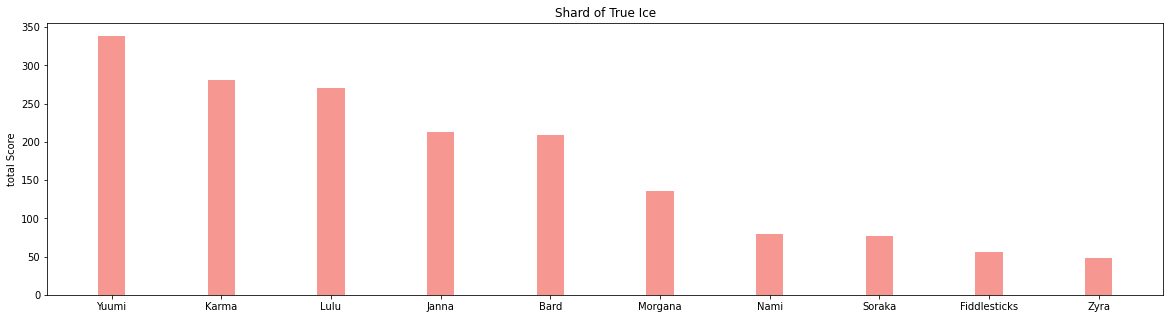

In [76]:
synergy_by_item()

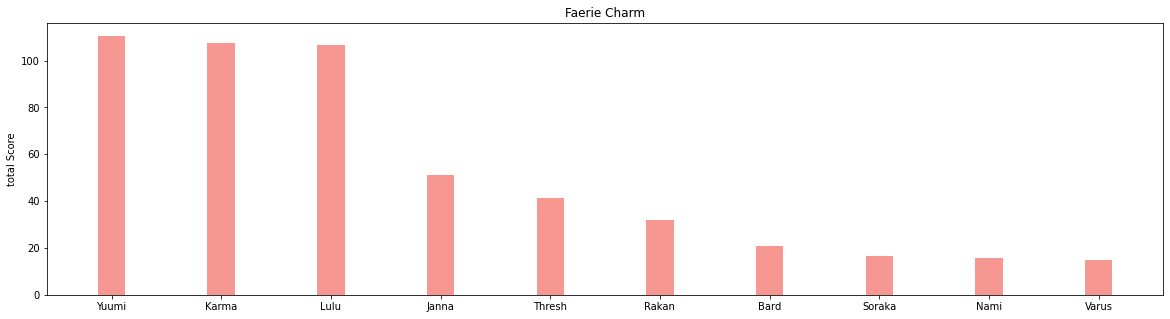

In [77]:
synergy_by_item('Faerie Charm')

#### Class Item Synergy 
This gets the top 3 classes that use this item by the usual score fuction

In [78]:
def class_item_synergies(row):
  class_dict= {}
  for val in row[1]:
    for cls in val[2:]:
      if(cls in class_dict):
        class_dict[cls] += 1
      else:
        class_dict[cls] = 1
    
      if(val[0] == True):
        class_dict[cls] += 0.5

  c = []
  for k, r in sorted(class_dict.items(), key=lambda x:x[1], reverse=True):
    c.append((k, r))

  return (row[0], c[:3])

In [83]:
item_class_synergy = items_champion.map(lambda x: class_item_synergies(x))
item_class_synergy_list = item_class_synergy.collect()

In [86]:
def class_synergy_by_item(search_item='Shard of True Ice'):
  item, c = zip(*item_class_synergy_list)
  # get names to be id1_id2
  for i in range(len(item_class_synergy_list)):
    if(search_item==item[i]):
      item_c_list = item_class_synergy_list[i][1]
      champs, score  = zip(*item_c_list)
      # create dictionary to be a pandas dataframe
      item_champion_table = {"champion": champs, "score": score}

      # plot
      c_df = pd.DataFrame(item_champion_table, columns = ['champion', 'score'])
      width = 0.25
      fig, ax = plt.subplots(figsize=(20,5))
      plt.bar(c_df["champion"], c_df["score"], width, alpha=0.5, color='#EE3224')
      ax.set_title(search_item)
      ax.set_ylabel('total Score')
      ax.set_xticklabels(c_df['champion'])
      plt.show()
      return
    
  print("Item not found!!")

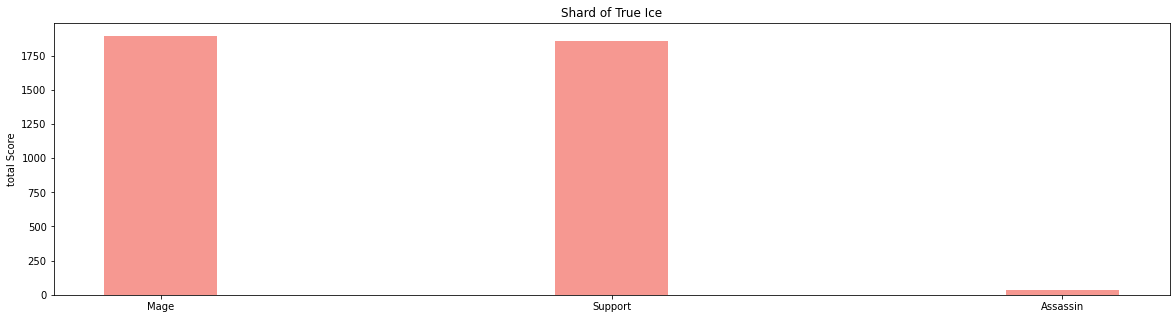

In [87]:
class_synergy_by_item()

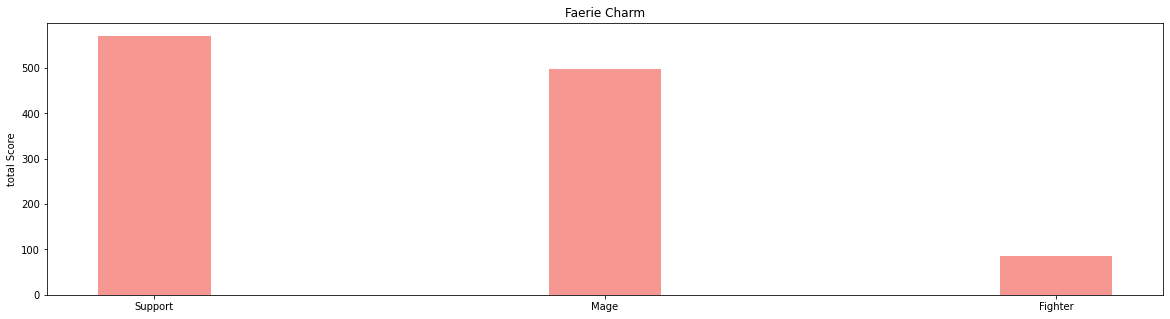

In [88]:
class_synergy_by_item('Faerie Charm')

## 5. Item suggestion
To get Item suggestions I got it like Item synergies but in backwards. I got what each champion mostly use out of all Items (legendary) Also giving higher weight (double) if this item is was on the winning team.

To do this:
1. loop over all participants
2. loop over all items of each participant and make sure it is a legendary Item
3. some time the "gold" feild is not there so it gives None object so I filter this as well.
4. the output is in this format (championId, (itemId, win/lose))

In [106]:
def champion_item(row):
  c = []
  for p in row["participants"]:
    # c.append(p["championId"])
    for i in range(7):
      if(p["stats"]["item"+str(i)]["gold"]):
        if (not p["stats"]["item"+str(i)]["into"]) and tags(p["championId"]) and (p["stats"]["item"+str(i)]["gold"]["total"] >= 1000):
          c.append((p["championId"], ( p["stats"]["item"+str(i)]["name"], p["stats"]["win"])))
  return  c

In [107]:
c_item = d.rdd.flatMap(champion_item).groupByKey().mapValues(list)


In [95]:
def champion_item_suggest(row):
  item_dict= {}
  for val in row[1]:
    if(val[0] in item_dict):
      item_dict[val[0]] += 1
    else:
      item_dict[val[0]] = 1
    
    if(val[0] == True):
            item_dict [val[0]] += 1

  c = []
  for k, r in sorted(item_dict.items(), key=lambda x:x[1], reverse=True):
    c.append((k, r))

  
  return (row[0], (c[:6]))

In [108]:
champion_item_suggestion = c_item_class.map(lambda x: champion_item_suggest(x))
c_item_list =  champion_item_suggestion.collect()

In [109]:
# for item in champion_item_suggestion.collect():
#     print(item)
#     time.sleep(0.01)

In [110]:
champs, items = zip(*c_item_list)

In [116]:
# this function takes the championId and gives back the highest 6 scoring function depending on the equation
def c_item_bar(search_champ='Lulu'):

  champs, items = zip(*c_item_list)
  # get names to be id1_id2
  for i in range(len(item_champion_list)):
    if(search_champ==champs[i]):
      items_list = items[i]
      champion_items_list, score  = zip(*items_list)
      # create dictionary to be a pandas dataframe
      item_champion_table = {"items": champion_items_list, "score": score}

      # plot
      c_df = pd.DataFrame(item_champion_table, columns = ['items', 'score'])
      width = 0.25
      fig, ax = plt.subplots(figsize=(20,5))
      plt.bar(c_df["items"], c_df["score"], width, alpha=0.5, color='#EE3224')
      ax.set_title(search_champ)
      ax.set_ylabel('total Score')
      ax.set_xticklabels(c_df['items'])
      plt.show()
      return
    
  print("Item not found!!")

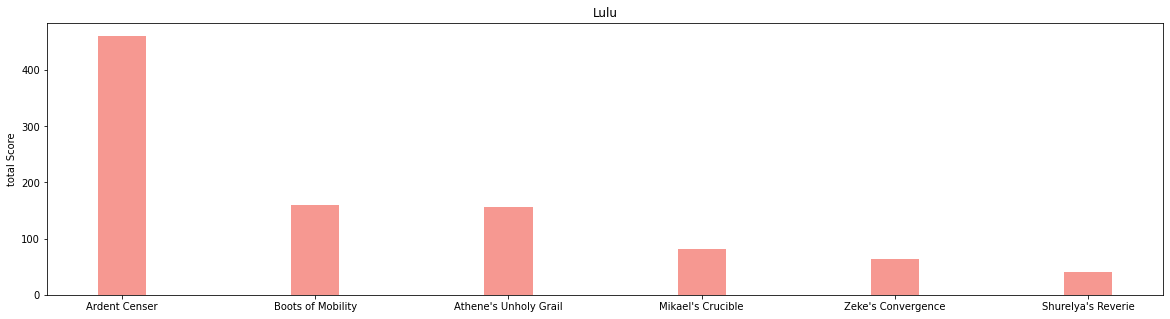

In [117]:
c_item_bar()

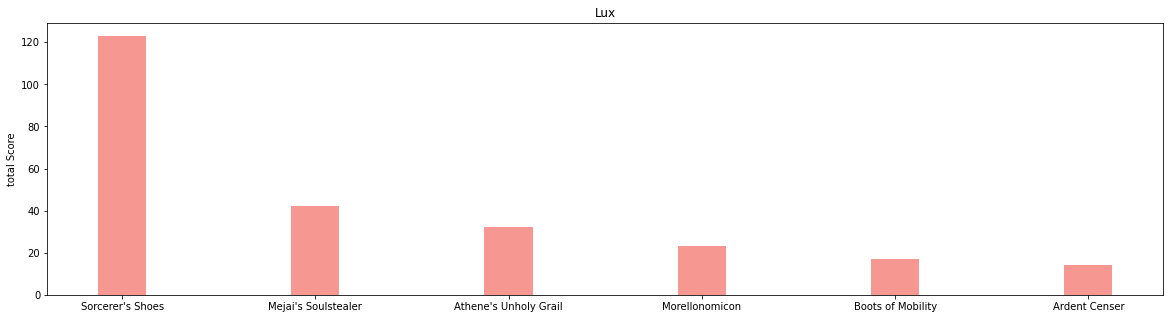

In [114]:
c_item_bar('Lux')